In [38]:
import os
from typing import TypedDict,Annotated,List,Literal

from click import prompt
from docutils.nodes import system_message
from langchain_core.messages import BaseMessage,HumanMessage,AIMessage,SystemMessage
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph,START,END,MessagesState
from langgraph.prebuilt import create_react_agent, ToolNode
from langgraph.checkpoint.memory import MemorySaver

In [39]:
os.environ['GROQ_API_KEY'] = "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"

In [40]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:llama-3.1-8b-instant")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001480994B1D0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001480BA7C890>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [41]:
class CEOState(MessagesState):
    """State for the ceo agent in the multi-agent system"""

    next_team: str = ""  # Next team leader to assign(eg reasearchteamleader
    overall_task:str = ""  # High-level task assigned to ceo
    team_updates: dict = {} # Updates receives from team leaders
    final_decision: str = "" # Ceo's final decision/output
    task_complete: bool = False  # Flag to mark task completion

In [42]:
## for Research Team Leader State

class ResearchTeamLeaderState(MessagesState):
    """ State for the research Team Leader """

    next_agent: str = ""  ## Which reseacher to assign ( data research)
    research_task: str = " "  ## sub-task for research
    collected_data: dict = {}  ## Data gathered from researchers
    summary_report: str = ""  ## Team Leader's summary of research
    task_complete: bool = False  ## wheather research is done

In [43]:
class WritingTeamLeaderState(MessagesState):
    """ State for the writing Team Leader """
    next_agent: str = ""
    writing_task: str = " "
    drafts: dict = {}
    compiled_report: str = ""
    task_complete: bool = False

In [62]:
llm = init_chat_model("groq:llama-3.1-8b-instant")
from langchain.prompts import ChatPromptTemplate

def create_ceo_chain(llm):
    ceo_prompt = ChatPromptTemplate.from_messages([
        ("system", """ you are the ceo managing the workflow.
Team Leaders available:
1. Research Team Leader - Manages research agents
2. Writing Team Leader - Manages writing agents

current state:
- Has research: {has_research}
- Has writing: {has_writing}
- Has final summary: {has_summary}

Decide which agent should act next.
Return Only one of: research_leader / writing_leader / Done
 """),
        ("human","{task}")
    ])
    return ceo_prompt | llm

In [63]:
def create_research_leader_chain(llm):
    research_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Research Team Leader.

Agents available:
1. Data Researcher - Collects factual/technical data
2. Market Researcher - Collects market/business data

Current state:
- Has data research: {has_data}
- Has market research: {has_market}

Decide which agent should act next.
Return ONLY one of: data_researcher / market_researcher / back_to_ceo
"""),
        ("human", "{task}")
    ])
    return research_prompt | llm


In [64]:
def create_writing_leader_chain(llm):
    writing_prompt = ChatPromptTemplate.from_messages([
        ("system", """You are the Writing Team Leader.
Agents available:
1. Technical Writer - Creates detailed technical reports
2. Summary Writer - Creates concise summary

current state:
- Has technical report: {has_report}
- Has summary: {has_summary}

Decide which agent should act next.
Return ONLY one of: technical_writer / summary_writer / back_to_ceo
        """),
        ("human", "{task}")
    ])
    return writing_prompt | llm

In [98]:
def ceo_agent(state: CEOState) -> dict:
    """CEO decides which team leader should act next"""

    task = state.get("current_task", "No task")
    has_research = bool(state.get("research_data", ""))
    has_report = bool(state.get("final_report", ""))
    has_summary = bool(state.get("final_summary", ""))

    # CEO chain (pass your LLM!)
    chain = create_ceo_chain(llm)
    decision = chain.invoke({
        "task": task,
        "has_research": has_research,
        "has_report": has_report,
        "has_summary": has_summary,
    })

    # UNWRAP list if returned
    if isinstance(decision, list):
        # Take the first AIMessage from the list
        decision = decision[0]

    decision_text = decision.content.strip().lower()
    print("CEO decision:", decision_text)

    # Decide next agent
    if "done" in decision_text or has_summary:
        next_agent = "end"
        ceo_msg = "✅ CEO: Project complete! Well done everyone."
    elif "research_leader" in decision_text or not has_research:
        next_agent = "research_leader"
        ceo_msg = "🧑‍💼 CEO: Assigning task to Research Team Leader."
    elif "writing_leader" in decision_text or (has_research and not has_summary):
        next_agent = "writing_leader"
        ceo_msg = "🧑‍💼 CEO: Research is ready. Assigning task to Writing Team Leader."
    else:
        next_agent = "end"
        ceo_msg = "✅ CEO: Task seems complete."

    # Return dict (single object) as expected by the workflow
    return {
        "messages": [AIMessage(content=ceo_msg)],
        "next_agent": next_agent,
        "current_task": task
    }




In [99]:
def research_leader_agent(state:ResearchTeamLeaderState) -> dict:
    """Research TL decides between Data Researcher and Market Researcher"""

    task = state.get("current_task", "No task")
    has_data = bool(state.get("data_research", ""))
    has_market = bool(state.get("market_research", ""))

    # LLM prompt (Research TL chain)
    chain = create_research_leader_chain()
    decision = chain.invoke({
        "task": task,
        "has_data": has_data,
        "has_market": has_market
    })

    decision_text = decision.content.strip().lower()
    print("Research TL decision:", decision_text)

    if "data_researcher" in decision_text or not has_data:
        next_agent = "data_researcher"
        tl_msg = "👨‍🔬 Research TL: Assigning task to Data Researcher."
    elif "market_researcher" in decision_text or (has_data and not has_market):
        next_agent = "market_researcher"
        tl_msg = "👩‍🔬 Research TL: Assigning task to Market Researcher."
    else:
        next_agent = "ceo"
        tl_msg = "👨‍🔬 Research TL: Both research tasks complete. Returning to CEO."

    return {
        "messages": [AIMessage(content=tl_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [100]:
def writing_leader_agent(state: WritingTeamLeaderState) -> dict:
    """Writing TL decides between Technical Writer and Summary Writer"""

    task = state.get("current_task", "No task")
    has_report = bool(state.get("technical_report", ""))
    has_summary = bool(state.get("final_summary", ""))

    # LLM prompt (Writing TL chain)
    chain = create_writing_leader_chain()
    decision = chain.invoke({
        "task": task,
        "has_report": has_report,
        "has_summary": has_summary
    })

    decision_text = decision.content.strip().lower()
    print("Writing TL decision:", decision_text)

    if "technical_writer" in decision_text or not has_report:
        next_agent = "technical_writer"
        tl_msg = "📝 Writing TL: Assigning task to Technical Writer."
    elif "summary_writer" in decision_text or (has_report and not has_summary):
        next_agent = "summary_writer"
        tl_msg = "📝 Writing TL: Assigning task to Summary Writer."
    else:
        next_agent = "ceo"
        tl_msg = "📝 Writing TL: Writing complete. Returning to CEO."

    return {
        "messages": [AIMessage(content=tl_msg)],
        "next_agent": next_agent,
        "current_task": task
    }


In [101]:
def data_researcher_agent(state: ResearchTeamLeaderState) -> dict:
    """Data Researcher gathers facts, statistics, and case studies"""
    task = state.get("current_task", "research topic")

    research_prompt = f"""As a Data Researcher, collect detailed information about: {task}

Include:
1. Key facts and background
2. Important statistics or data points
3. Relevant case studies
Be concise but thorough."""

    response = llm.invoke([HumanMessage(content=research_prompt)])
    research_data = response.content

    agent_message = f"📊 Data Researcher: Collected factual data for '{task}'.\n\nSample:\n{research_data[:400]}..."

    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": research_data,
        "next_agent": "research_team_leader"
    }


In [102]:
def market_researcher_agent(state: ResearchTeamLeaderState) -> dict:
    """Market Researcher gathers trends, opportunities, and risks"""
    task = state.get("current_task", "market topic")

    market_prompt = f"""As a Market Researcher, analyze trends related to: {task}

Include:
1. Current market trends
2. Opportunities and risks
3. Competitor landscape
4. Industry developments"""

    response = llm.invoke([HumanMessage(content=market_prompt)])
    research_data = response.content

    agent_message = f"📈 Market Researcher: Completed market analysis for '{task}'.\n\nHighlights:\n{research_data[:400]}..."

    return {
        "messages": [AIMessage(content=agent_message)],
        "research_data": state.get("research_data", "") + "\n" + research_data,
        "next_agent": "research_team_leader"
    }


In [103]:
def technical_writer_agent(state: WritingTeamLeaderState) -> dict:
    """Technical Writer creates structured detailed report"""
    task = state.get("current_task", "writing topic")
    analysis = state.get("analysis", "")
    research_data = state.get("research_data", "")

    writing_prompt = f"""As a Technical Writer, create a structured detailed report on: {task}

Use:
- Research findings: {research_data[:1000]}
- Analysis: {analysis[:1000]}

Format:
1. Title
2. Executive Summary
3. Detailed Findings
4. Insights and Recommendations
"""

    response = llm.invoke([HumanMessage(content=writing_prompt)])
    report = response.content

    agent_message = f"📝 Technical Writer: Drafted detailed report for '{task}'."

    return {
        "messages": [AIMessage(content=agent_message)],
        "final_report": report,
        "next_agent": "writing_team_leader"
    }


In [104]:
def summary_writer_agent(state: WritingTeamLeaderState) -> dict:
    """Summary Writer creates executive summary"""
    task = state.get("current_task", "writing topic")
    full_report = state.get("final_report", "")

    summary_prompt = f"""As a Summary Writer, create a concise executive summary for: {task}

Base it on this report:
{full_report[:1500]}

Keep it under 300 words, highlighting key insights and recommendations."""

    response = llm.invoke([HumanMessage(content=summary_prompt)])
    summary = response.content

    agent_message = f"📄 Summary Writer: Completed executive summary for '{task}'."

    return {
        "messages": [AIMessage(content=agent_message)],
        "final_report": full_report + "\n\n---\nExecutive Summary:\n" + summary,
        "task_complete": True,
        "next_agent": "writing_team_leader"
    }


In [105]:
from typing import Literal
from langgraph.constants import END

def router(state: CEOState) -> Literal[
    "ceo",
    "research_leader",
    "writing_leader",
    "data_researcher",
    "market_researcher",
    "technical_writer",
    "summary_writer",
    "__end__"
]:
    """Routes to next agent based on state (CEO → Leaders → Workers)"""

    next_agent = state.get("next_agent", "ceo")

    # End condition
    if next_agent == "end" or state.get("task_complete", False):
        return END

    # Allowable agents
    valid_agents = [
        "ceo",
        "research_leader",
        "writing_leader",
        "data_researcher",
        "market_researcher",
        "technical_writer",
        "summary_writer"
    ]

    if next_agent in valid_agents:
        return next_agent

    # Default fallback → CEO
    return "ceo"


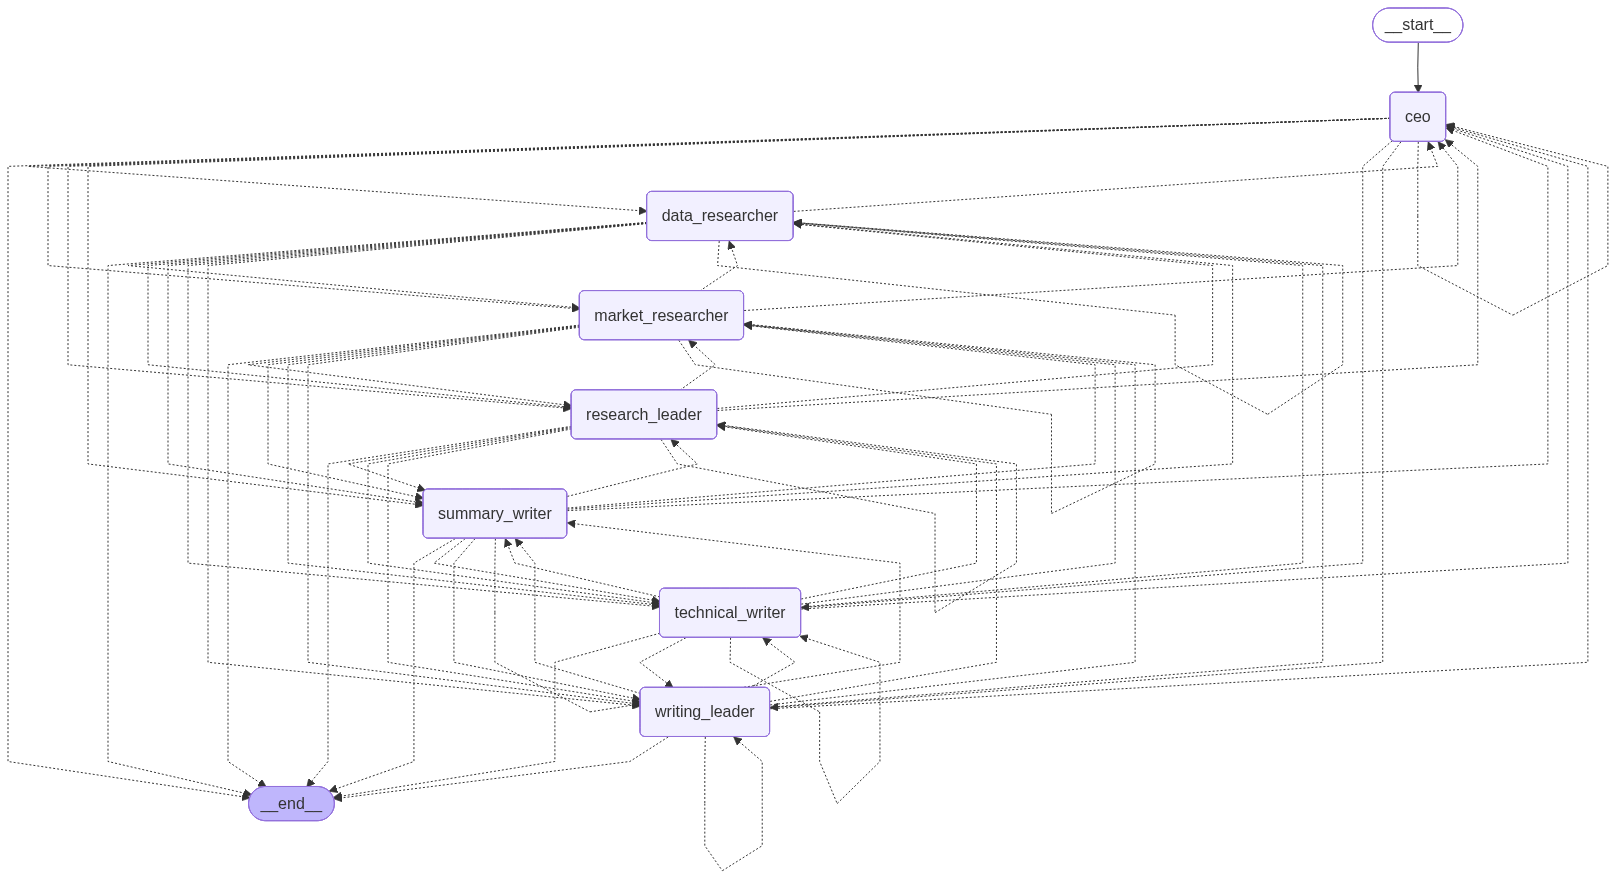

In [106]:
# Create workflow
workflow = StateGraph(CEOState)

# === Add nodes (agents) ===
# Add CEO node
workflow.add_node("ceo", create_ceo_chain)
workflow.add_node("research_leader", lambda s: create_research_leader_chain(s, "research"))
workflow.add_node("writing_leader", lambda s: create_writing_leader_chain(s, "writing"))



# Workers under research team
workflow.add_node("data_researcher", data_researcher_agent)
workflow.add_node("market_researcher", market_researcher_agent)

# Workers under writing team
workflow.add_node("technical_writer", technical_writer_agent)
workflow.add_node("summary_writer", summary_writer_agent)

# === Set entry point ===
workflow.set_entry_point("ceo")

# === Add routing logic ===
for node in [
    "ceo",
    "research_leader",
    "writing_leader",
    "data_researcher",
    "market_researcher",
    "technical_writer",
    "summary_writer"
]:
    workflow.add_conditional_edges(
        node,
        router,   # 👈 our router function
        {
            "ceo": "ceo",
            "research_leader": "research_leader",
            "writing_leader": "writing_leader",
            "data_researcher": "data_researcher",
            "market_researcher": "market_researcher",
            "technical_writer": "technical_writer",
            "summary_writer": "summary_writer",
            END: END
        }
    )

# === Compile graph ===
graph = workflow.compile()

# Show graph structure
graph


In [108]:
response = graph.invoke(HumanMessage(content=" What are the benefits and risks of Ai in healthcare."))

TypeError: Expected a Runnable, callable or dict.Instead got an unsupported type: <class 'list'>